**Exploring Star/Galaxy Separation and the Extendedness Parameter**

Author: Melissa Graham

Last verified to run: Sat Oct 15 2022

Last verified to run with RSP image: Weekly 2022_40

Container size: medium

<br>

**Goal of this notebook.**

This notebook is intended to provide a brief introduction to the extendedness parameter as calculated for the DP0.2 data set.
Additional notebooks analyzing the extendedness parameter, or performing other types of star/galaxy separation with the DP0.2 data set, would be very welcome additions.

<br>

**Introduction to star/galaxy separation parameters for the DP0.2 data set.**

The <a href="https://dm.lsst.org/sdm_schemas/browser/dp02.html#Object">DP0.2 Object table schema</a> specifies that the `refExtendedness` parameter is _"Set to 1 for extended sources, 0 for point sources. Reference band."_, and that there are also per-band extendedness parameters.

As the DP0.2 data set is based on simulated data, there is also truth information about whether the Object is a star or a galaxy, which can be compared with the measured properties in the Object table.

As Rubin staff member Dan Taranu describes in <a href="https://community.lsst.org/t/how-is-the-extendedness-parameter-calculated-for-dp0-2-objects/7091">this Community Forum topic on extendedness</a>, Objects are considered "not extended" (extendedness parameter = 0) if the product of the model flux and a configurable ratio is less than the PSF flux.
The default model flux used to calculated extendedness is the `cModelFlux`.
The extendedness parameter is calculated in the code <a href="https://github.com/lsst/meas_base/blob/main/python/lsst/meas/base/classification.py">classification.py</a> in the `meas_base` package, in which the <a href="https://github.com/lsst/obs_lsst/blob/main/config/cmodel.py#L27">flux ratio is defined to be 0.985</a>.

> **How could this information about extendedness have been discovered by users independently?**<br>
> If one starts at <a href="pipelines.lsst.io">pipelines.lsst.io</a> and searches for the term "extendedness", the existence of the <a href="https://pipelines.lsst.io/py-api/lsst.meas.base.CatalogCalculationClassificationPlugin.html">Classification Plugin</a> can be discovered, and one can find that the _"extendedness is based on a simple cut of the ratio of the PSF flux to the model flux"_.
Clicking on the "fluxRatio" under "Notes" leads to <a href="https://pipelines.lsst.io/py-api/lsst.meas.base.CatalogCalculationClassificationConfig.html">the Classification Configuration page</a>, where fluxRatio is defined to be 0.925.
The fact that the fluxRatio is overridden to be 0.985 would only be discoverable by a user that goes to the source code. 
In the future, the documentation will have to be much clearer about details like this.

<br>

**More information about star/galaxy separation for LSST Objects in future (real) data releases.**

The Data Management Science Pipelines Design Document (ls.st/ldm-151) has Section 6.20 on star/galaxy separation, which says this parameter will be a probability in the future, not boolean.

The paper <a href="https://ui.adsabs.harvard.edu/abs/2020AJ....159...65S/abstract">Slater et al. (2020), “Morphological Star-Galaxy Separation” </a> is generally a good resource for learning more about star/galaxy separation.

<br>

## 1.0 Set up

Import packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lsst.rsp import get_tap_service, retrieve_query

Start TAP service.

In [2]:
service = get_tap_service()

Plot settings.

In [3]:
%matplotlib inline
font = {'size' : 12}
plt.rc('font', **font)

## 2.0 Retrieve data from the Object and Truth tables

Define the TAP query and retrieve a set of random truth-table entries that are matched to Objects.

Retrieve their true type, coordinates, redshift, and magnitudes.

Retrieve their measured coordinates, extendedness parameter, and magnitudes.

In [4]:
query = "SELECT mt.id_truth_type AS mt_id_truth_type, "\
        "mt.match_objectId AS mt_match_objectId, "\
        "ts.ra AS ts_ra, "\
        "ts.dec AS ts_dec, "\
        "ts.truth_type AS ts_truth_type, "\
        "ts.mag_r AS ts_mag_r, "\
        "ts.is_pointsource AS ts_is_pointsource, "\
        "ts.redshift AS ts_redshift, "\
        "obj.coord_ra AS obj_coord_ra, "\
        "obj.coord_dec AS obj_coord_dec, "\
        "obj.refExtendedness AS obj_refExtendedness, "\
        "obj.refBand as obj_refBand, "\
        "obj.g_extendedness AS obj_g_extendedness, "\
        "obj.r_extendedness AS obj_r_extendedness, "\
        "obj.i_extendedness AS obj_i_extendedness, "\
        "obj.g_extendedness_flag AS obj_g_extendedness_flag, "\
        "obj.r_extendedness_flag AS obj_r_extendedness_flag, "\
        "obj.i_extendedness_flag AS obj_i_extendedness_flag, "\
        "scisql_nanojanskyToAbMag(obj.g_cModelFlux) AS obj_cModelMag_g, "\
        "scisql_nanojanskyToAbMag(obj.r_cModelFlux) AS obj_cModelMag_r, "\
        "scisql_nanojanskyToAbMag(obj.i_cModelFlux) AS obj_cModelMag_i, "\
        "obj.g_cModelFlux AS obj_g_cModelFlux, "\
        "obj.r_cModelFlux AS obj_r_cModelFlux, "\
        "obj.i_cModelFlux AS obj_i_cModelFlux, "\
        "obj.g_cModelFluxErr AS obj_g_cModelFluxErr, "\
        "obj.r_cModelFluxErr AS obj_r_cModelFluxErr, "\
        "obj.i_cModelFluxErr AS obj_i_cModelFluxErr, "\
        "obj.g_psfFlux AS obj_g_psfFlux, "\
        "obj.r_psfFlux AS obj_r_psfFlux, "\
        "obj.i_psfFlux AS obj_i_psfFlux, "\
        "obj.g_psfFluxErr AS obj_g_psfFluxErr, "\
        "obj.r_psfFluxErr AS obj_r_psfFluxErr, "\
        "obj.i_psfFluxErr AS obj_i_psfFluxErr, "\
        "obj.g_psfFlux_flag AS obj_g_psfFlux_flag, "\
        "obj.r_psfFlux_flag AS obj_r_psfFlux_flag, "\
        "obj.i_psfFlux_flag AS obj_i_psfFlux_flag "\
        "FROM dp02_dc2_catalogs.MatchesTruth AS mt "\
        "JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type "\
        "JOIN dp02_dc2_catalogs.Object AS obj ON mt.match_objectId = obj.objectId "\
        "WHERE CONTAINS(POINT('ICRS', ts.ra, ts.dec), CIRCLE('ICRS', 62.0, -37.0, 0.10)) = 1 "\
        "AND obj.detect_isPrimary = 1"

print(query)

SELECT mt.id_truth_type AS mt_id_truth_type, mt.match_objectId AS mt_match_objectId, ts.ra AS ts_ra, ts.dec AS ts_dec, ts.truth_type AS ts_truth_type, ts.mag_r AS ts_mag_r, ts.is_pointsource AS ts_is_pointsource, ts.redshift AS ts_redshift, obj.coord_ra AS obj_coord_ra, obj.coord_dec AS obj_coord_dec, obj.refExtendedness AS obj_refExtendedness, obj.refBand as obj_refBand, obj.g_extendedness AS obj_g_extendedness, obj.r_extendedness AS obj_r_extendedness, obj.i_extendedness AS obj_i_extendedness, obj.g_extendedness_flag AS obj_g_extendedness_flag, obj.r_extendedness_flag AS obj_r_extendedness_flag, obj.i_extendedness_flag AS obj_i_extendedness_flag, scisql_nanojanskyToAbMag(obj.g_cModelFlux) AS obj_cModelMag_g, scisql_nanojanskyToAbMag(obj.r_cModelFlux) AS obj_cModelMag_r, scisql_nanojanskyToAbMag(obj.i_cModelFlux) AS obj_cModelMag_i, obj.g_cModelFlux AS obj_g_cModelFlux, obj.r_cModelFlux AS obj_r_cModelFlux, obj.i_cModelFlux AS obj_i_cModelFlux, obj.g_cModelFluxErr AS obj_g_cModelFluxE

In [5]:
%%time
job = service.submit_job(query)
print('Job URL is', job.url)
print('Job phase is', job.phase)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job URL is https://data.lsst.cloud/api/tap/async/fldayp03i8duxo5o
Job phase is PENDING
Job phase is COMPLETED
CPU times: user 54.7 ms, sys: 3.85 ms, total: 58.5 ms
Wall time: 3min 39s


In [6]:
job.raise_if_error()

In [7]:
results = job.fetch_result()

In [8]:
del job

In [9]:
# results.fieldnames

## 3.0 Explore the extendedness parameter

Recall that truth type 1 means galaxy, 2 means star, and 3 means Type Ia supernova.

In [10]:
str_index = np.where(results['ts_truth_type'] == 2)[0]
gal_index = np.where(results['ts_truth_type'] == 1)[0]

print('Number of true stars = ', len(str_index))
print('Number of true galaxies = ', len(gal_index))

Number of true stars =  349
Number of true galaxies =  14501


Show:
1. What fraction of true stars are measured to be extended? (Extendedness parameter = 1).
2. What fraction of true galaxies are measured to be point-like? (Extendedness parameter = 0).

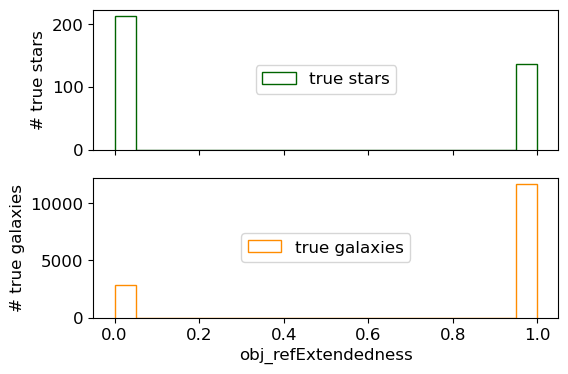

In [11]:
fig, ax = plt.subplots(2, figsize=(6,4), sharex=True)
ax[0].hist(results['obj_refExtendedness'][str_index], bins=20, \
           histtype='step', color='darkgreen', label='true stars')
ax[1].hist(results['obj_refExtendedness'][gal_index], bins=20, \
           histtype='step', color='darkorange', label='true galaxies')
ax[0].legend(loc='center')
ax[1].legend(loc='center')
ax[1].set_xlabel('obj_refExtendedness')
ax[0].set_ylabel('# true stars')
ax[1].set_ylabel('# true galaxies')
plt.show()

In [12]:
tx1 = np.where(results['obj_refExtendedness'][str_index] == 1)[0]
tx2 = np.where(results['obj_refExtendedness'][gal_index] == 0)[0]
print('Fraction of true stars that are measured as extended = ', \
      np.round(float(len(tx1))/float(len(str_index)),2))
print('Fraction of true galaxies that are measured as point-like = ', \
      np.round(float(len(tx2))/float(len(gal_index)),2))
del tx1, tx2

Fraction of true stars that are measured as extended =  0.39
Fraction of true galaxies that are measured as point-like =  0.19


Recall that the `obj_refExtendedness` parameter is associated with a band. 

Use a histogram to show which band is most commonly used.

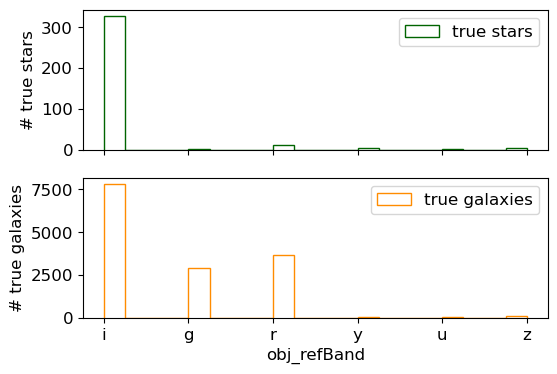

In [13]:
fig, ax = plt.subplots(2, figsize=(6,4), sharex=True)
ax[0].hist(results['obj_refBand'][str_index], bins=20, \
           histtype='step', color='darkgreen', label='true stars')
ax[1].hist(results['obj_refBand'][gal_index], bins=20, \
           histtype='step', color='darkorange', label='true galaxies')
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')
ax[1].set_xlabel('obj_refBand')
ax[0].set_ylabel('# true stars')
ax[1].set_ylabel('# true galaxies')
plt.show()

Explore the "extended" stars and "point-like" galaxies -- are they all just misclassified due to being faint?

In [14]:
ext_str_index = np.where((results['ts_truth_type'] == 2) & (results['obj_refExtendedness'] == 1))[0]
pnt_str_index = np.where((results['ts_truth_type'] == 2) & (results['obj_refExtendedness'] == 0))[0]
ext_gal_index = np.where((results['ts_truth_type'] == 1) & (results['obj_refExtendedness'] == 1))[0]
pnt_gal_index = np.where((results['ts_truth_type'] == 1) & (results['obj_refExtendedness'] == 0))[0]

Based on the plot below, it does appear that most missclassified objects are faint.

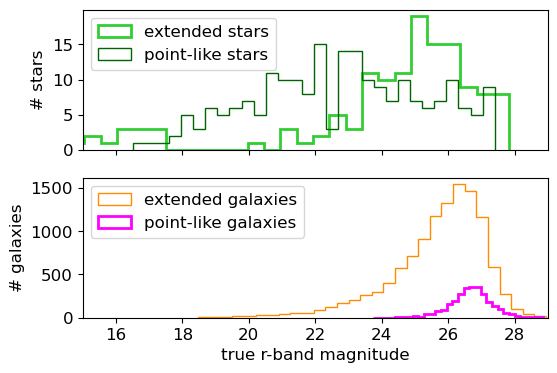

In [15]:
fig, ax = plt.subplots(2, figsize=(6,4), sharex=True)
ax[0].hist(results['ts_mag_r'][ext_str_index], bins=30, histtype='step', \
           color='limegreen', lw=2, label='extended stars')
ax[0].hist(results['ts_mag_r'][pnt_str_index], bins=30, histtype='step', \
           color='darkgreen', label='point-like stars')
ax[0].legend(loc='upper left')
ax[1].hist(results['ts_mag_r'][ext_gal_index], bins=30, histtype='step', \
           color='darkorange', label='extended galaxies')
ax[1].hist(results['ts_mag_r'][pnt_gal_index], bins=30, histtype='step', \
           color='magenta', lw=2, label='point-like galaxies')
ax[1].legend(loc='upper left')
ax[1].set_xlabel('true r-band magnitude')
ax[0].set_ylabel('# stars')
ax[1].set_ylabel('# galaxies')
ax[1].set_xlim([15,29])
plt.show()

## 4.0 Demonstrate how `refExtendedness` is calculated

As described above, DP0.2 Objects should have an extendedness parameter equal to zero when the ratio of the `psfFlux` over the `cModelFlux` is greater than the `fluxRatio`, 0.985.

In [16]:
fluxRatio = 0.985

### 4.1 For individual filters

Plot the ratio of the `psfFlux` / `cModelFlux` as a function of apparent magnitude (left column) and as a function of the extendedness parameter (right column), for each of filter g, r, and i.

Only include Objects in the plot if they meet certain conditions:
1. They have a truth type of 1 or 2 (stars and galaxies only).
1. Their extendedness and PSF flux flags are zero.
2. Their cModelFlux and psfFlux detections have a signal-to-noise ratio > 5.

> **Question for further study:** why does the plot below show that not all Objects with `psfFlux` / `cModelFlux` > `fluxRatio` are assigned an extendedness parameter of 0 (point-like)?

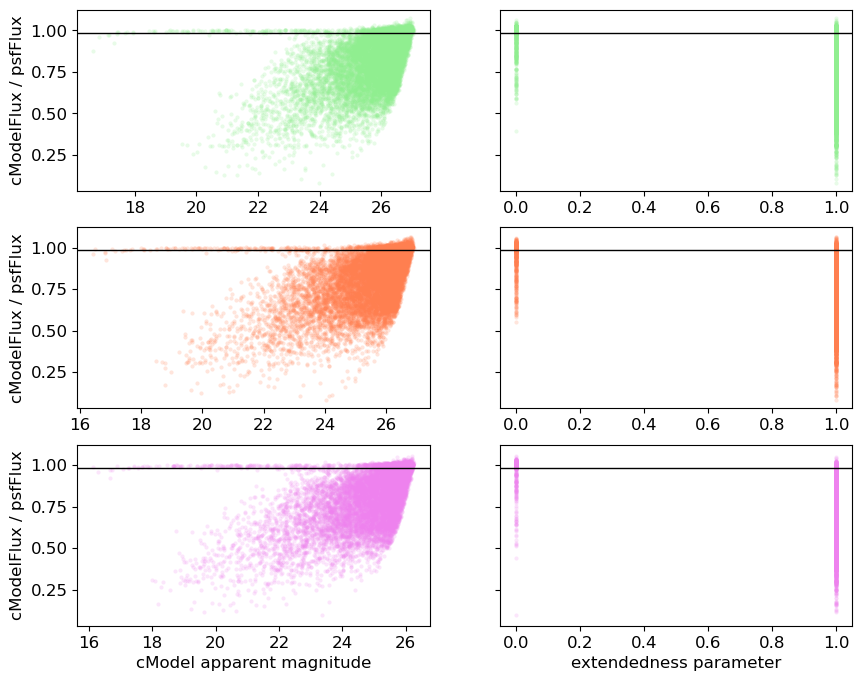

In [30]:
fig, ax = plt.subplots(3, 2, figsize=(10,8), sharey=True)

filters = ['g','r','i']
fcolors = ['lightgreen','coral','violet']

for f,filt in enumerate(filters):

    tx = np.where(((results['ts_truth_type'] == 1) | (results['ts_truth_type'] == 2)) & \
                  (results['obj_'+filt+'_extendedness_flag'] == 0) & \
                  (results['obj_'+filt+'_psfFlux_flag'] == 0) & \
                  (results['obj_'+filt+'_cModelFlux']/results['obj_'+filt+'_cModelFluxErr'] > 5.0) & \
                  (results['obj_'+filt+'_psfFlux']/results['obj_'+filt+'_psfFluxErr'] > 5.0))[0]

    ax[f,0].plot(results['obj_cModelMag_'+filt][tx], \
                 results['obj_'+filt+'_psfFlux'][tx]/results['obj_'+filt+'_cModelFlux'][tx],\
                 'o', ms=3, alpha=0.2, mew=0, color=fcolors[f])
    ax[f,0].axhline(fluxRatio, lw=1, color='black')

    ax[f,1].plot(results['obj_'+filt+'_extendedness'][tx], \
               results['obj_'+filt+'_psfFlux'][tx]/results['obj_'+filt+'_cModelFlux'][tx],\
               'o', ms=3, alpha=0.2, mew=0, color=fcolors[f])
    ax[f,1].axhline(fluxRatio, lw=1, color='black')
    
    del tx
    ax[f,0].set_ylabel('cModelFlux / psfFlux')

ax[2,0].set_xlabel('cModel apparent magnitude')
ax[2,1].set_xlabel('extendedness parameter')
plt.show()

### 4.2 Using the reference band

Unlike for filters g, r, and i above, we can see that when we only consider the reference band, all Objects with `psfFlux` / `cModelFlux` > `fluxRatio` in the `refBand` are assigned a `refExtendedness` parameter of 0 (point-like).

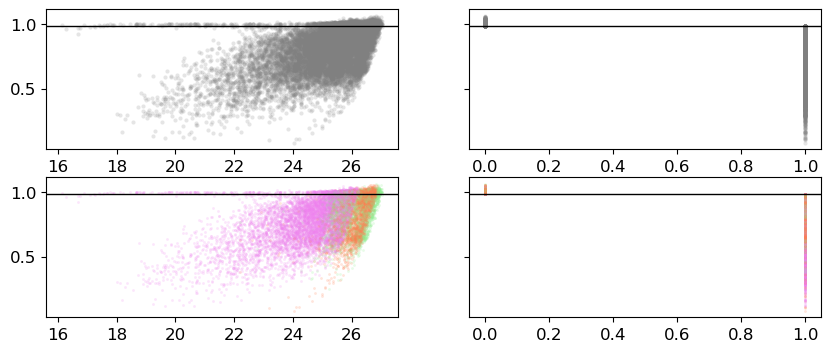

In [40]:
fig, ax = plt.subplots(2, 2, figsize=(10,4), sharey=True)

fcd = {'g':0, 'r':1, 'i':2}

for r in range(len(results)):
    b = results['obj_refBand'][r]

    if ((b == 'g') | (b == 'r') | (b == 'i')):
        
        if ((results['ts_truth_type'][r] == 1) | (results['ts_truth_type'][r] == 2)):
            
            if (results['obj_'+b+'_extendedness_flag'][r] == 0) & \
            (results['obj_'+b+'_psfFlux_flag'][r] == 0) & \
            (results['obj_'+b+'_cModelFlux'][r]/results['obj_'+b+'_cModelFluxErr'][r] > 5.0) & \
            (results['obj_'+b+'_psfFlux'][r]/results['obj_'+b+'_psfFluxErr'][r] > 5.0):
                
                ax[0,0].plot(results['obj_cModelMag_'+b][r], \
                           results['obj_'+b+'_psfFlux'][r]/results['obj_'+b+'_cModelFlux'][r],\
                           'o', ms=3, alpha=0.2, mew=0, color='grey')
                ax[0,1].plot(results['obj_refExtendedness'][r], \
                           results['obj_'+b+'_psfFlux'][r]/results['obj_'+b+'_cModelFlux'][r],\
                           'o', ms=3, alpha=0.2, mew=0, color='grey')

                ax[1,0].plot(results['obj_cModelMag_'+b][r], \
                           results['obj_'+b+'_psfFlux'][r]/results['obj_'+b+'_cModelFlux'][r],\
                           'o', ms=2, alpha=0.2, mew=0, color=fcolors[fcd[b]])
                ax[1,1].plot(results['obj_refExtendedness'][r], \
                           results['obj_'+b+'_psfFlux'][r]/results['obj_'+b+'_cModelFlux'][r],\
                           'o', ms=2, alpha=0.2, mew=0, color=fcolors[fcd[b]])

ax[0,0].axhline(fluxRatio, lw=1, color='black')
ax[0,1].axhline(fluxRatio, lw=1, color='black')
ax[1,0].axhline(fluxRatio, lw=1, color='black')
ax[1,1].axhline(fluxRatio, lw=1, color='black')
plt.show()